  0%|          | 0/10 [00:00<?, ?it/s]/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
 10%|█         | 1/10 [00:35<05:17, 35.24s/it]/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/users/ug20g1/miniconda3

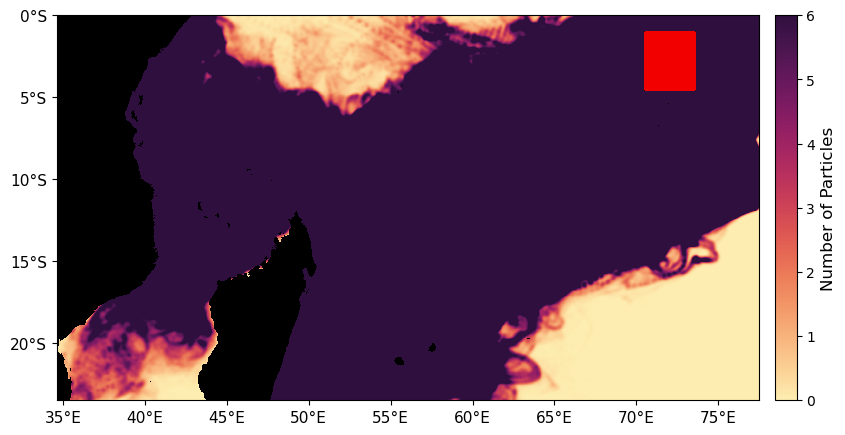

In [2]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cmasher as cmr
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import cmocean


grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

years = [2001,2002,2003,2004,2005, 2006, 2007, 2008, 2009, 2010]
days = [10,16]

all_data =[]

for day in days:
    for year in tqdm(years):
        data = xr.open_dataset(f'/home/ocean_personal_data/albinski/Trajs/a_validation_{year}_09_{day}_31w.zarr')
        lon_flat = data.lon.values.flatten()
        lat_flat = data.lat.values.flatten()
        hist_count, _, _ = np.histogram2d(lon_flat, lat_flat, bins=[grid.lon_psi[0, :], grid.lat_psi[:, 0]])
        all_data.append(hist_count.T)

overall_sum = np.nansum(all_data, axis =0 )

smoothed_values_all = gaussian_filter(overall_sum, sigma=5, mode='nearest')
f, ax = plt.subplots(1,1, figsize=(20,5))

cmap2 = ax.pcolormesh(grid.lon_psi[0, :], grid.lat_psi[:, 0], smoothed_values_all, cmap=cmocean.cm.matter, vmin=0, vmax=6)

cbar = plt.colorbar(cmap2, ax=ax, orientation='vertical', pad=0.01, aspect=17.5, fraction=0.03)
cbar.set_label('Number of Particles', fontsize=12)

cbar.ax.tick_params(labelsize=10)

ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]),
                                 mask=grid.mask_rho[1:-1, 1:-1]),
              cmap=cmr.neutral)

ax.scatter(data.lon_initial, data.lat_initial, c='r', s=0.01, marker='.')
plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))
ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=11)

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

y_ticks_labels = [f"{int(abs(tick))}°S" for tick in y_ticks]

x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

ax.set_yticklabels(y_ticks_labels)
ax.set_xticklabels(x_ticks_labels)

ax.set_aspect('equal')
plt.show()

Coarsened and each bottle a different colour

/tmp/ipykernel_2880708/2593560520.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_2880708/2593560520.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


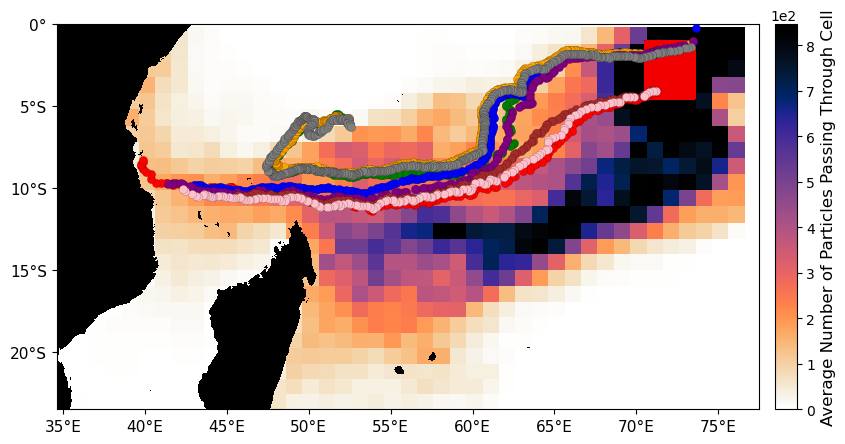

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from matplotlib.ticker import ScalarFormatter

data_array = xr.DataArray(smoothed_values_all, dims=["eta_psi", "xi_psi"],
                          coords={"lat": (["eta_psi", "xi_psi"], grid.lat_psi.values[:-1, :-1]),
                                  "lon": (["eta_psi", "xi_psi"], grid.lon_psi.values[:-1, :-1])})

factor_lat = 50
factor_lon = 50
coarsened = data_array.coarsen(eta_psi=factor_lat, xi_psi=factor_lon, boundary='trim').mean()

percentile_99 = np.nanpercentile(coarsened, 95)
f, ax = plt.subplots(figsize=(20,5))
cmap2 = ax.pcolormesh(coarsened.lon, coarsened.lat, coarsened,
                      cmap=cmr.torch_r, vmin = 0, vmax = percentile_99)
cbar = plt.colorbar(cmap2, ax=ax, orientation='vertical', pad=0.01, aspect=17.5, fraction=0.03, label='Normalised Risk')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label('Average Number of Particles Passing Through Cell', fontsize=12)

ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]),
                                 mask=grid.mask_rho[1:-1, 1:-1]),
              cmap=cmr.neutral)
ax.scatter(data.lon_initial, data.lat_initial, c='r', s=0.01, marker='.')
plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))
ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=11)

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

y_ticks_labels = [f"{int(abs(tick))}°S" if tick < 0 else f"{int(tick)}°" for tick in y_ticks]
x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

ax.set_yticklabels(y_ticks_labels)
ax.set_xticklabels(x_ticks_labels)


import pandas as pd

directory = '/home/ocean_personal_data/albinski/bottle_data/'

colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
color_index = 0

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename))
        plt.plot(df['Longitude'], df['Latitude'], zorder=100, marker='o', 
                 markerfacecolor=colors[color_index], markeredgecolor='black', 
                 markeredgewidth=0.1, linestyle='None')
        color_index = (color_index + 1) % len(colors)


plt.savefig('domain_map.png', dpi=1000, format='png', bbox_inches='tight')
plt.show()



Coarsened and each month a different colour

/tmp/ipykernel_3289998/2675663511.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_3289998/2675663511.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


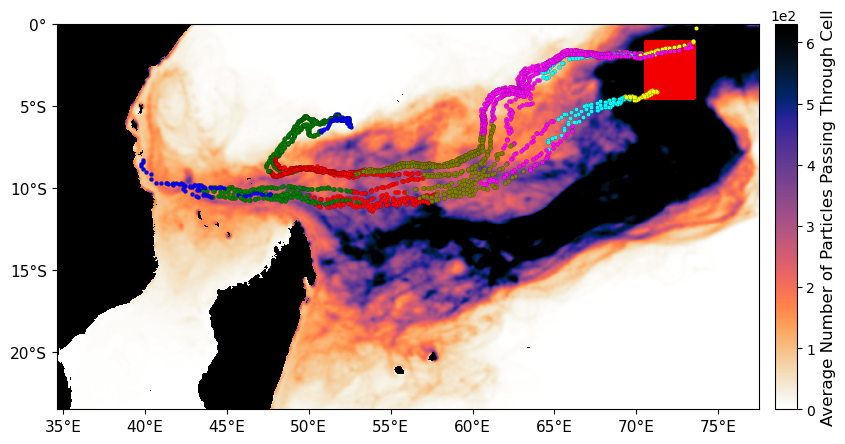

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from matplotlib.ticker import ScalarFormatter

data_array = xr.DataArray(smoothed_values_all, dims=["eta_psi", "xi_psi"],
                          coords={"lat": (["eta_psi", "xi_psi"], grid.lat_psi.values[:-1, :-1]),
                                  "lon": (["eta_psi", "xi_psi"], grid.lon_psi.values[:-1, :-1])})

factor_lat = 1
factor_lon = 1
coarsened = data_array.coarsen(eta_psi=factor_lat, xi_psi=factor_lon, boundary='trim').mean()

percentile_99 = np.nanpercentile(coarsened, 90)
f, ax = plt.subplots(figsize=(20,5))
cmap2 = ax.pcolormesh(coarsened.lon, coarsened.lat, coarsened,
                      cmap=cmr.torch_r, vmin = 0, vmax = percentile_99)
cbar = plt.colorbar(cmap2, ax=ax, orientation='vertical', pad=0.01, aspect=17.5, fraction=0.03, label='Normalised Risk')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label('Average Number of Particles Passing Through Cell', fontsize=12)

ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]),
                                 mask=grid.mask_rho[1:-1, 1:-1]),
              cmap=cmr.neutral)
ax.scatter(data.lon_initial, data.lat_initial, c='r', s=0.01, marker='.')
plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))
ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=11)

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

y_ticks_labels = [f"{int(abs(tick))}°S" if tick < 0 else f"{int(tick)}°" for tick in y_ticks]
x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

ax.set_yticklabels(y_ticks_labels)
ax.set_xticklabels(x_ticks_labels)


import pandas as pd

directory = '/home/ocean_personal_data/albinski/bottle_data/'

month_colors = {
    1: 'red', 2: 'green', 3: 'blue', 4: 'orange', 
    5: 'purple', 6: 'brown', 7: 'pink', 8: 'gray', 
    9: 'yellow', 10: 'cyan', 11: 'magenta', 12: 'olive'
}

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename))
        df['Month'] = pd.to_datetime(df['Msg Date'], dayfirst=True, errors='coerce').dt.month
        for month in df['Month'].unique():
            month_df = df[df['Month'] == month]
            plt.plot(month_df['Longitude'], month_df['Latitude'], zorder=100, marker='.', 
                     markerfacecolor=month_colors.get(month, 'black'), markeredgecolor='black', 
                     markeredgewidth=0.1, linestyle='None')

plt.savefig('domain_map.png', dpi=1000, format='png', bbox_inches='tight')
plt.show()
